## 🤖 Webscrapping de Ámbito Financiero

Mediante un bot de webscrapping vamos a descargar los <b>datos históricos del reisgo país de la Argentina</b>. 

Para ello, ingresaremos a la web de <b>Ámbito Financiero</b>, cliquearemos en el filtro de la fecha, le daremos una fecha de inicio, ejecutaremos, y convertiremos la <b>tabla HTML</b> que nos brinda a <b>Pandas DataFrame</b>.

Una vez que tengamos el DataFrame, vamos a crear gráficos con Matplotlib y Seaborn. Al ser una serie de tiempo, usaremos un <b>gráfico lineal</b>.

Hay que recordar que el riesgo país se basa en puntos base que cada 100 son un requerimiento al país de 1% por arriba de la tasa pagada por el bono más seguro de los Estados Unidos.

In [4]:
# Manejar el tiempo y contar el tiempo de ejecución
import time
comienzo = time.perf_counter()

# Convertir los datos en DataFrame y transformar
import pandas as pd

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Opciones de Selenium, son típicas
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Ingresamos a la web de ambito financiero
    driver = webdriver.Chrome("chromedriver", options=chrome_options)
    driver.get("https://www.ambito.com/contenidos/riesgo-pais-historico.html")

    # Cliquear filtro desplegable de fecha de inicio
    filtro_fecha = driver.find_element(
        "xpath", "/html/body/main/div/div[1]/div[10]/div[1]/div[1]/input"
    )
    filtro_fecha.click()

    # Limpiamos y ponemos una fecha menor que la mínima que acepta la web para que nos dé el máximo que pueda
    filtro_fecha.clear()
    filtro_fecha.send_keys("05/06/1995")

    # Ejecutar el botón para filtrar la tabla esperando a que aparezca
    boton_filtrar = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located(
            ("xpath", "/html/body/main/div/div[1]/div[10]/div[1]/button")
        )
    )
    driver.execute_script("arguments[0].click();", boton_filtrar)

    # Esperar a que la tabla cargue, sin wait, sino toma los datos antes de que termine de cargar
    time.sleep(3)

    # Buscamos la tabla
    tabla = driver.find_element("xpath", "/html/body/main/div/div[1]/div[10]/table")

    # Tomamos el contenido HTML de la tabla
    tabla = tabla.get_attribute("outerHTML")

    # Desde el HTML creamos el dataframe con pandas
    riesgo_pais_df = pd.read_html(tabla)[0]
    riesgo_pais_df["Fecha"] = pd.to_datetime(riesgo_pais_df["Fecha"], dayfirst=True)
    riesgo_pais_df["Puntos"] = riesgo_pais_df["Puntos"] // 100

# Cerramos el navegador
finally:
    driver.quit()

# Exportamos a Excel
riesgo_pais_df.to_excel("Riesgo País.xlsx")

# Imprimir tiempo de ejecución y dataframe
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
{riesgo_pais_df}"""
)


La duración de la ejecución total fue de: 14.11 segundos.
          Fecha  Puntos
0    2023-06-27    2120
1    2023-06-26    2095
2    2023-06-23    2232
3    2023-06-22    2216
4    2023-06-21    2307
...         ...     ...
6328 1998-12-17     758
6329 1998-12-16     760
6330 1998-12-15     734
6331 1998-12-14     766
6332 1998-12-11     720

[6333 rows x 2 columns]


## 📈 Gráfico Lineal Histórico

Teniendo los datos históricos del riesgo país de la Argentina desde fines de 1998 a hoy podemos visualizarlo mediante un gráfico lineal y rellenarlo hasta el eje X para darle más impacto.

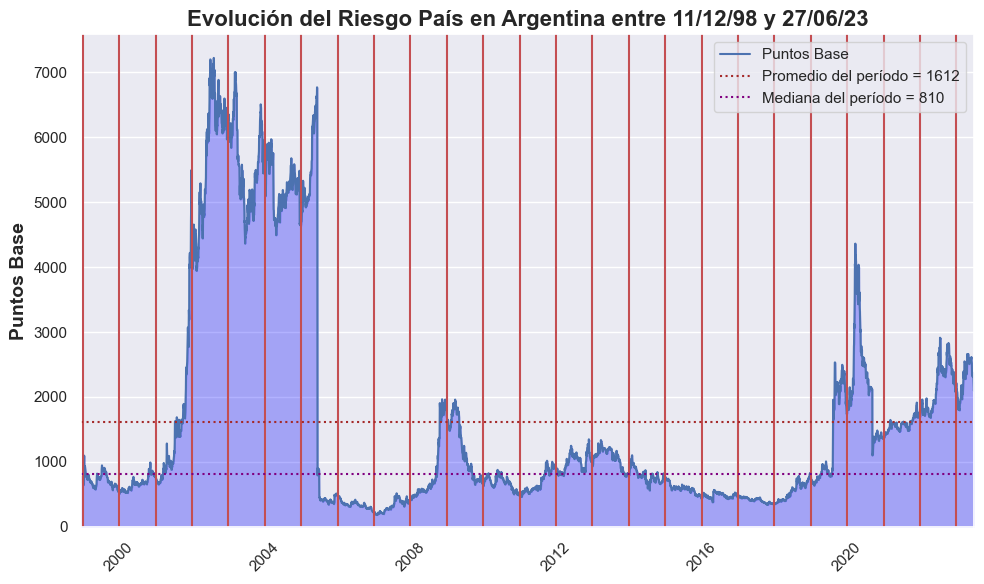


La duración de la ejecución total fue de: 15.89 segundos.



In [5]:
# Elegir estilo y crear figura
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar línea
sns.lineplot(
    data=riesgo_pais_df, x="Fecha", y="Puntos", color="b", ax=ax, label="Puntos Base"
)

fecha_min = riesgo_pais_df["Fecha"].min()
fecha_max = riesgo_pais_df["Fecha"].max()

# Configurar ejes
ax.set_xlabel("")
ax.set_ylabel(
    "Puntos Base",
    fontweight="bold",
    fontsize=14
)
ax.set_title(
    f'Evolución del Riesgo País en Argentina entre {fecha_min.strftime("%d/%m/%y")} y {fecha_max.strftime("%d/%m/%y")}',
    fontweight='bold',
    fontsize=16
)

# Líneas verticales rojas al comenzar cada año
for year in range(
    riesgo_pais_df["Fecha"].min().year, riesgo_pais_df["Fecha"].max().year + 2
):
    date = pd.to_datetime(f"01/01/{year}", format="%d/%m/%Y")
    ax.axvline(date, color="r", linestyle="-")

# Ajustamos los límites del eje x e y
ax.set_xlim(fecha_min, fecha_max)
ax.set_ylim(0, riesgo_pais_df["Puntos"].max() * 1.05)


# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

# Rellenamos el espacio hacia abajo
plt.fill_between(
    riesgo_pais_df["Fecha"], riesgo_pais_df["Puntos"], color="blue", alpha=0.3
)

# Linea promedio total horizontal
promedio_periodo = riesgo_pais_df["Puntos"].mean()
ax.axhline(
    promedio_periodo,
    color="brown",
    linestyle=":",
    label=f"Promedio del período = {promedio_periodo:.0f}",
)

# Linea mediana total horizontal
mediana_periodo = riesgo_pais_df["Puntos"].median()
ax.axhline(
    mediana_periodo,
    color="purple",
    linestyle=":",
    label=f"Mediana del período = {mediana_periodo:.0f}",
)

# Activar leyenda
plt.legend()

# Descargar gráfico
plt.savefig(
    f'Riesgo País Histórico {fecha_min.strftime("%d-%m-%y")} a {fecha_max.strftime("%d-%m-%y")}.jpg'
)
# Mostrar gráfico
plt.tight_layout()
plt.show()

# Imprimir tiempo de ejecución
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
"""
)

Con el gráfico podemos ver los grandes picos luego de la crisis del 2001, la caída del riesgo país en junio de 2004 ante los pagos de deuda durante la gestión de Néstor Kirchner, un nuevo máximos entre 2008 y 2009 durante la crisis del 2008 ciertos idas y vueltas entre el 2011 y el 2015.

En el 2015 con la llegadade Macri a la presidencia, los Estados e inversores internacionales aumentaron la confianza en la Argentina. Sin embargo, los desequilibrios macroeconómicos permanentes de la Argentina continuaron hasta que en 2018 empieza la gran devaluación, empeorando aún más con la inminente derrota en las elecciones presidenciales del 2019.

Con la llegada de Alberto Fernández al poder, hay un aumento en el riesgo país pero no se compara con el gran aumento de principios del 2020, cuando la Pandemia de COVID-19 empieza a dañar la ya golpeada economía Argentina.

A mediados del 2020 conseguimos un mínimo en el riesgo país de aproximadamente 1.500 puntos bases, lo cual según muchos autores, con más de 1.000 ya es suficiente para repeler inversiones. Desde ahí hay un aumento constante y sostenido.

## Gráficos Históricos divididos por año

Para poder ver más en detalle, podemos generar una iteración que bajo el listado de años, cree subgráficos lineales similares, con un similar eje de X e Y facilitando la lectura vertical y comparación año a año.

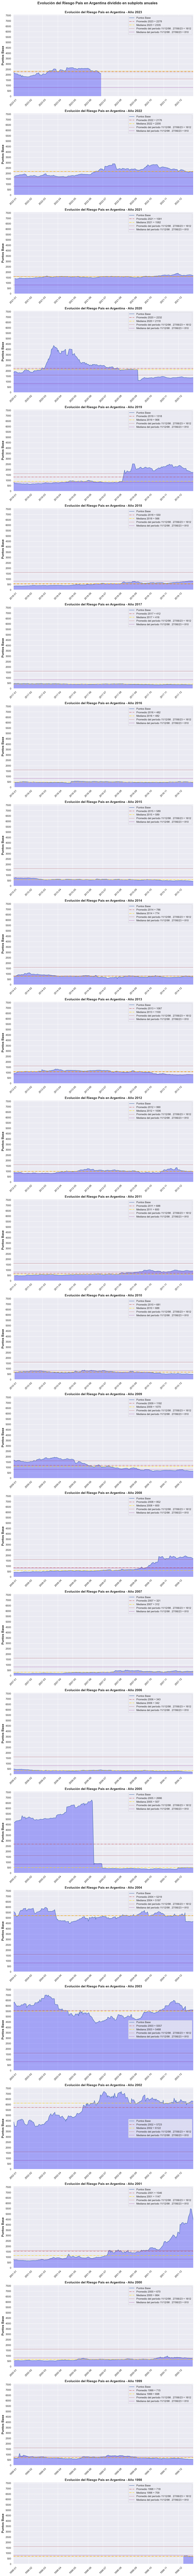


La duración de la ejecución total fue de: 45.69 segundos.



In [6]:
# Obtener los años únicos en el DataFrame
años = riesgo_pais_df["Fecha"].dt.year.unique()

# Crear figura y subplots por año, en forma vertical uno bajo el otro
fig, axs = plt.subplots(
    nrows=len(años), ncols=1, figsize=(12, len(años) * 6), sharex=False
)

# Título general
fig.suptitle(
    "Evolución del Riesgo País en Argentina dividido en subplots anuales",
    fontweight="bold",
    fontsize=16,
    y=1
)

# Iterar sobre los subplots y los años correspondientes
for ax, year in zip(axs.flatten(), años):

    # Filtrar los datos por año
    df_year = riesgo_pais_df[riesgo_pais_df["Fecha"].dt.year == year]

    # Graficar línea
    sns.lineplot(
        data=df_year, x="Fecha", y="Puntos", color="b", ax=ax, label="Puntos Base"
    )
    
    # Título subplots
    ax.set_title(
        f"Evolución del Riesgo País en Argentina - Año {year}",
        fontweight="bold",
        fontsize=14,
    )

    # Configurar títulos de ejes
    ax.set_xlabel("")
    ax.set_ylabel(
        "Puntos Base",
        fontweight="bold",
        fontsize = 14
    )

    # Establecer límites del eje X según el mínimo y el máximo de la fecha correspondiente
    ax.set_xlim(
        pd.to_datetime(f"01/01/{year}", format="%d/%m/%Y"),
        pd.to_datetime(f"31/12/{year}", format="%d/%m/%Y"),
    )

    # Rotar etiquetas del eje X para mayor legibilidad
    ax.tick_params(axis="x", rotation=45)

    # Configurar límites y ticks del eje Y, que vayan del 0 a 5% arriba del máximo
    ax.set_ylim(0, riesgo_pais_df["Puntos"].max() * 1.05)
    # Y que vayan de 250 en 250 los major ticks
    ax.yaxis.set_major_locator(plt.MultipleLocator(500))

    # Línea horizontal del promedio del año
    promedio_año = df_year["Puntos"].mean()
    ax.axhline(
        promedio_año,
        color="r",
        linestyle="-.",
        label=f"Promedio {year} = {promedio_año:.0f}",
    )

    # Línea horizontal de la mediana del año
    mediana_año = df_year["Puntos"].median()
    ax.axhline(
        mediana_año,
        color="gold",
        linestyle="-.",
        label=f"Mediana {year} = {mediana_año:.0f}",
    )

    # Linea promedio total horizontal
    promedio_periodo = riesgo_pais_df["Puntos"].mean()
    ax.axhline(
        promedio_periodo,
        color="brown",
        linestyle=":",
        label=f'Promedio del período {fecha_min.strftime("%d/%m/%y")} . {fecha_max.strftime("%d/%m/%y")} = {promedio_periodo:.0f}',
    )

    # Linea mediana total horizontal
    mediana_periodo = riesgo_pais_df["Puntos"].median()
    ax.axhline(
        mediana_periodo,
        color="purple",
        linestyle=":",
        label=f"Mediana del período {fecha_min.strftime('%d/%m/%y')} . {fecha_max.strftime('%d/%m/%y')} = {mediana_periodo:.0f}",
    )
    
    # Rellenar el área hacia abajo
    ax.fill_between(df_year["Fecha"], df_year["Puntos"], color="blue", alpha=0.3)

    # Leyenda
    ax.legend()

# Descargar gráfico
plt.savefig(
    f'Riesgo País anual {fecha_min.strftime("%d-%m-%y")} a {fecha_max.strftime("%d-%m-%y")}.jpg'
)

# Mostrar gráfico
plt.tight_layout()
plt.show()

# Imprimir tiempo de ejecución
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
"""
)